## Yelp Rating Prediction FCNN

Author: Rahul Gupta

Goal of the project is to develop an FCNN (Fully Connected Neural Network) to predict Yelp rating scores based on the text data from user-written reviews.

### Data Loading
Need to first load, understand, and preprocess data for the neural network.

In [1]:
import numpy as np
import pandas as pd

# Starter code
review = pd.read_json('./data/yelp_academic_dataset_review.json', lines=True, nrows= 1000000)
business = pd.read_json('./data/yelp_academic_dataset_business.json', lines=True, nrows= 1000000)

In [2]:
review.dropna(inplace=True)
print(review.shape)
review.head()

(1000000, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [3]:
business.dropna(inplace=True)
print(business.shape)
business.head()

(117618, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."


In [4]:
# Drop businesses with less than 20 reviews
business_to_drop = business[business['review_count'] < 20]

business_filtered = business[business['review_count'] >= 20]

# Remove reviews for businesses that aren't in business_filtered
review_filtered = review[review['business_id'].isin(business_filtered['business_id']) == True]

### First Approach - Group all reviews
Join the tables together such that we have a business and all the reviews for each business in one row.

We'll use TFIDF on all the reviews for a business to predict the business's rating.

In [5]:
from scipy.stats import zscore

df_review_agg = review_filtered.groupby('business_id')['text'].sum()

df_grouped = pd.DataFrame({
    'business_id': df_review_agg.index, 
    'all_reviews': df_review_agg.values,
    })

# Join the business star ratings w/ business IDs
# Normalize the star ratings
df_grouped = df_grouped.merge(business_filtered[['business_id', 'stars']], on='business_id', how='inner')
df_grouped['stars'] = zscore(df_grouped['stars'])

print(df_grouped.shape)
df_grouped.head()

(10769, 3)


,business_id,all_reviews,stars
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,1.055696
1,-02xFuruu85XmDn2xiynJw,Dr. Curtis Dechant has an excellent chair-side...,1.055696
2,-06OYKiIzxsdymBMDAKZug,Had catalytic converters replaced on our Subur...,1.055696
3,-06ngMH_Ejkm_6HQBYxB7g,I have an old main line that really should be ...,0.442790
4,-0E7laYjwZxEAQPhFJXxow,I recently visited this dealership because the...,-0.170116


#### Applying TFIDF
Use TFIDF on review text to extract relevant features. Ignore stop words.

In [6]:
import sklearn.feature_extraction.text as sk_text

vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

In [7]:
vectorizer.get_feature_names_out()[:40]

array(['10', '20', '30', 'able', 'absolutely', 'actually', 'amazing',
       'area', 'ask', 'asked', 'atmosphere', 'attentive', 'away',
       'awesome', 'bad', 'bar', 'beef', 'beer', 'best', 'better', 'big',
       'bit', 'bread', 'breakfast', 'burger', 'business', 'busy',
       'called', 'came', 'car', 'care', 'check', 'cheese', 'chicken',
       'city', 'clean', 'coffee', 'cold', 'come', 'coming'], dtype=object)

#### Train Test Split
Splitting the training and resting data (80/20)

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### RSME Function

In [9]:
from sklearn import metrics

# Predict and measure RMSE
def print_rsme(model, x_test, y_test):
    pred = model.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    
    print("RMSE Score: {}".format(score))


#### Lift Chart Function

In [10]:
# Function from lab #4
import matplotlib.pyplot as plt

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Plot the chart
# chart_regression(pred.flatten(),y_test, sort=True)

#### Basic FCNN
No dropout layers, just a basic fully connected neural network.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

basic_fcnn_model = Sequential()

basic_fcnn_model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
basic_fcnn_model.add(Dense(250, activation='relu'))
basic_fcnn_model.add(Dense(125, activation='relu'))
basic_fcnn_model.add(Dense(60, activation='relu'))
basic_fcnn_model.add(Dense(30, activation='relu'))
basic_fcnn_model.add(Dense(15, activation='relu'))
basic_fcnn_model.add(Dense(1))

basic_fcnn_model.compile(loss='mean_squared_error', optimizer='adam')

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
basic_fcnn_model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)



c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 3s - 11ms/step - loss: 0.3750 - val_loss: 0.2638
Epoch 2/1000
270/270 - 1s - 3ms/step - loss: 0.2568 - val_loss: 0.2354
Epoch 3/1000
270/270 - 1s - 3ms/step - loss: 0.2236 - val_loss: 0.2342
Epoch 4/1000
270/270 - 1s - 4ms/step - loss: 0.1810 - val_loss: 0.2549
Epoch 5/1000
270/270 - 1s - 3ms/step - loss: 0.1522 - val_loss: 0.2743
Epoch 6/1000
270/270 - 1s - 3ms/step - loss: 0.1270 - val_loss: 0.2705
Epoch 7/1000
270/270 - 1s - 3ms/step - loss: 0.1081 - val_loss: 0.2460
Epoch 8/1000
270/270 - 1s - 3ms/step - loss: 0.0892 - val_loss: 0.2510
Epoch 8: early stopping


In [12]:
print_rsme(basic_fcnn_model, x_test, y_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE Score: 0.5009668026087557


#### Slower Learning Rate
Basic FCNN but using a slower learning rate.

In [13]:
from tensorflow.keras import optimizers

slow_fcnn_model = Sequential()

slow_fcnn_model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
slow_fcnn_model.add(Dense(250, activation='relu'))
slow_fcnn_model.add(Dense(125, activation='relu'))
slow_fcnn_model.add(Dense(60, activation='relu'))
slow_fcnn_model.add(Dense(30, activation='relu'))
slow_fcnn_model.add(Dense(15, activation='relu'))
slow_fcnn_model.add(Dense(1))

adam_modified = optimizers.Adam(learning_rate=0.0001)

slow_fcnn_model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
slow_fcnn_model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 3s - 10ms/step - loss: 0.6093 - val_loss: 0.3294
Epoch 2/1000
270/270 - 1s - 3ms/step - loss: 0.2924 - val_loss: 0.2446
Epoch 3/1000
270/270 - 1s - 3ms/step - loss: 0.2614 - val_loss: 0.2373
Epoch 4/1000
270/270 - 1s - 3ms/step - loss: 0.2425 - val_loss: 0.2306
Epoch 5/1000
270/270 - 1s - 3ms/step - loss: 0.2269 - val_loss: 0.2307
Epoch 6/1000
270/270 - 1s - 3ms/step - loss: 0.2129 - val_loss: 0.2314
Epoch 7/1000
270/270 - 1s - 3ms/step - loss: 0.1955 - val_loss: 0.2598
Epoch 8/1000
270/270 - 1s - 3ms/step - loss: 0.1825 - val_loss: 0.2315
Epoch 9/1000
270/270 - 1s - 3ms/step - loss: 0.1639 - val_loss: 0.2341
Epoch 9: early stopping


In [14]:
print_rsme(slow_fcnn_model, x_test, y_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE Score: 0.483788435837562


#### Dropout FCNN
Same model as the basic fcnn, just with dropout layers implemented in between. Ideally, this will generalize the model more

In [15]:
# Add dropout layers
from tensorflow.keras.layers import Dropout

dropout_fcnn_model = Sequential()

dropout_fcnn_model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
dropout_fcnn_model.add(Dropout(0.1))
dropout_fcnn_model.add(Dense(250, activation='relu'))
dropout_fcnn_model.add(Dropout(0.1))
dropout_fcnn_model.add(Dense(125, activation='relu'))
dropout_fcnn_model.add(Dropout(0.1))
dropout_fcnn_model.add(Dense(60, activation='relu'))
dropout_fcnn_model.add(Dropout(0.1))
dropout_fcnn_model.add(Dense(30, activation='relu'))
dropout_fcnn_model.add(Dropout(0.1))
dropout_fcnn_model.add(Dense(15, activation='relu'))
dropout_fcnn_model.add(Dense(1))

dropout_fcnn_model.compile(loss='mean_squared_error', optimizer='adam')

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
dropout_fcnn_model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 3s - 10ms/step - loss: 0.4270 - val_loss: 0.2349
Epoch 2/1000
270/270 - 1s - 4ms/step - loss: 0.2841 - val_loss: 0.2417
Epoch 3/1000
270/270 - 1s - 4ms/step - loss: 0.2461 - val_loss: 0.2349
Epoch 4/1000
270/270 - 1s - 4ms/step - loss: 0.2136 - val_loss: 0.2376
Epoch 5/1000
270/270 - 1s - 4ms/step - loss: 0.1826 - val_loss: 0.2318
Epoch 6/1000
270/270 - 1s - 4ms/step - loss: 0.1524 - val_loss: 0.2411
Epoch 7/1000
270/270 - 1s - 4ms/step - loss: 0.1385 - val_loss: 0.2386
Epoch 8/1000
270/270 - 1s - 4ms/step - loss: 0.1263 - val_loss: 0.2408
Epoch 9/1000
270/270 - 1s - 4ms/step - loss: 0.1106 - val_loss: 0.2517
Epoch 10/1000
270/270 - 1s - 4ms/step - loss: 0.1015 - val_loss: 0.2328
Epoch 10: early stopping


In [16]:
print_rsme(dropout_fcnn_model, x_test, y_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE Score: 0.4825024228409628


Not much of a difference noticed with dropout

#### Adjusting Hyperparameters
We'll be using the slower learning rate adam optimizer from before, since it yielded slightly lower RSME.


##### Changing Max Features
Adjusting the max number of features for TFIDF

In [17]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=500, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(1000, input_dim=x.shape[1], activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1))

adam_modified = optimizers.Adam(learning_rate=0.0001)

model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 4s - 14ms/step - loss: 0.4662 - val_loss: 0.2347
Epoch 2/1000
270/270 - 2s - 8ms/step - loss: 0.2436 - val_loss: 0.2278
Epoch 3/1000
270/270 - 2s - 8ms/step - loss: 0.2004 - val_loss: 0.2191
Epoch 4/1000
270/270 - 2s - 8ms/step - loss: 0.1747 - val_loss: 0.2280
Epoch 5/1000
270/270 - 2s - 8ms/step - loss: 0.1477 - val_loss: 0.2439
Epoch 6/1000
270/270 - 2s - 8ms/step - loss: 0.1183 - val_loss: 0.2246
Epoch 7/1000
270/270 - 2s - 8ms/step - loss: 0.0940 - val_loss: 0.2292
Epoch 8/1000
270/270 - 2s - 8ms/step - loss: 0.0746 - val_loss: 0.2408
Epoch 8: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE Score: 0.4906708569319917


##### Use SGD

In [ ]:
# Using SGD instead of Adam

vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=500, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(1000, input_dim=x.shape[1], activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1))

adam_modified = optimizers.SGD(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 1s - 5ms/step - loss: 1.0026 - val_loss: 0.9845
Epoch 2/1000
270/270 - 1s - 4ms/step - loss: 1.0002 - val_loss: 0.9812
Epoch 3/1000
270/270 - 1s - 4ms/step - loss: 0.9957 - val_loss: 0.9749
Epoch 4/1000
270/270 - 1s - 4ms/step - loss: 0.9878 - val_loss: 0.9652
Epoch 5/1000
270/270 - 1s - 4ms/step - loss: 0.9767 - val_loss: 0.9522
Epoch 6/1000
270/270 - 1s - 4ms/step - loss: 0.9619 - val_loss: 0.9352
Epoch 7/1000
270/270 - 1s - 4ms/step - loss: 0.9414 - val_loss: 0.9127
Epoch 8/1000
270/270 - 1s - 4ms/step - loss: 0.9138 - val_loss: 0.8791
Epoch 9/1000
270/270 - 1s - 4ms/step - loss: 0.8752 - val_loss: 0.8330
Epoch 10/1000
270/270 - 1s - 4ms/step - loss: 0.8205 - val_loss: 0.7669
Epoch 11/1000
270/270 - 1s - 4ms/step - loss: 0.7442 - val_loss: 0.6770
Epoch 12/1000
270/270 - 1s - 4ms/step - loss: 0.6452 - val_loss: 0.5667
Epoch 13/1000
270/270 - 1s - 4ms/step - loss: 0.5322 - val_loss: 0.4530
Epoch 14/1000
270/270 - 1s - 4ms/step - loss: 0.4353 - val_loss: 0.3668
E

##### Smaller Number of Layers and Neurons

In [36]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=1000, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(1))

adam_modified = optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 3s - 11ms/step - loss: 0.3153 - val_loss: 0.2108
Epoch 2/1000
270/270 - 2s - 6ms/step - loss: 0.1933 - val_loss: 0.2365
Epoch 3/1000
270/270 - 2s - 6ms/step - loss: 0.1331 - val_loss: 0.2242
Epoch 4/1000
270/270 - 2s - 6ms/step - loss: 0.0904 - val_loss: 0.2255
Epoch 5/1000
270/270 - 2s - 6ms/step - loss: 0.0689 - val_loss: 0.2278
Epoch 6/1000
270/270 - 2s - 6ms/step - loss: 0.0518 - val_loss: 0.2272
Epoch 6: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE Score: 0.4766763963276964


##### Smaller Number of Layers and Neurons w/ Dropout
Also using 2k words for vectorizer

In [45]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=2000, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(125, activation='relu'))
model.add(Dense(1))

adam_modified = optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 5s - 18ms/step - loss: 0.3250 - val_loss: 0.2104
Epoch 2/1000
270/270 - 3s - 13ms/step - loss: 0.1786 - val_loss: 0.2184
Epoch 3/1000
270/270 - 3s - 12ms/step - loss: 0.1167 - val_loss: 0.2294
Epoch 4/1000
270/270 - 3s - 12ms/step - loss: 0.0834 - val_loss: 0.2159
Epoch 5/1000
270/270 - 3s - 12ms/step - loss: 0.0621 - val_loss: 0.2135
Epoch 6/1000
270/270 - 3s - 11ms/step - loss: 0.0481 - val_loss: 0.2219
Epoch 6: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE Score: 0.4710981124564769


##### Testing different dropout values

In [47]:
model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(125, activation='relu'))
model.add(Dense(1))

adam_modified = optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 5s - 18ms/step - loss: 0.3657 - val_loss: 0.2296
Epoch 2/1000
270/270 - 3s - 11ms/step - loss: 0.2198 - val_loss: 0.2260
Epoch 3/1000
270/270 - 3s - 11ms/step - loss: 0.1734 - val_loss: 0.2337
Epoch 4/1000
270/270 - 3s - 11ms/step - loss: 0.1438 - val_loss: 0.2079
Epoch 5/1000
270/270 - 3s - 11ms/step - loss: 0.1180 - val_loss: 0.2147
Epoch 6/1000
270/270 - 3s - 12ms/step - loss: 0.1000 - val_loss: 0.2149
Epoch 7/1000
270/270 - 3s - 12ms/step - loss: 0.0890 - val_loss: 0.2134
Epoch 8/1000
270/270 - 3s - 11ms/step - loss: 0.0798 - val_loss: 0.2138
Epoch 9/1000
270/270 - 4s - 15ms/step - loss: 0.0767 - val_loss: 0.2222
Epoch 9: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE Score: 0.4713762617153123


##### Reduce by 1 layer

In [48]:
model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(125, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

adam_modified = optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 4s - 15ms/step - loss: 0.3575 - val_loss: 0.2220
Epoch 2/1000
270/270 - 3s - 10ms/step - loss: 0.2232 - val_loss: 0.2098
Epoch 3/1000
270/270 - 3s - 10ms/step - loss: 0.1782 - val_loss: 0.2115
Epoch 4/1000
270/270 - 3s - 10ms/step - loss: 0.1471 - val_loss: 0.2121
Epoch 5/1000
270/270 - 3s - 10ms/step - loss: 0.1215 - val_loss: 0.2185
Epoch 6/1000
270/270 - 3s - 10ms/step - loss: 0.1087 - val_loss: 0.2176
Epoch 7/1000
270/270 - 3s - 10ms/step - loss: 0.0935 - val_loss: 0.2178
Epoch 7: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE Score: 0.46664243596131105


##### 10k TFIDF Features w/ SGD

In [61]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=10000, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [62]:
model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(125, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

sgd_modified = optimizers.SGD(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=sgd_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 5s - 18ms/step - loss: 1.0031 - val_loss: 0.9835
Epoch 2/1000
270/270 - 4s - 15ms/step - loss: 1.0005 - val_loss: 0.9800
Epoch 3/1000
270/270 - 4s - 15ms/step - loss: 0.9971 - val_loss: 0.9761
Epoch 4/1000
270/270 - 4s - 15ms/step - loss: 0.9937 - val_loss: 0.9718
Epoch 5/1000
270/270 - 4s - 15ms/step - loss: 0.9888 - val_loss: 0.9666
Epoch 6/1000
270/270 - 4s - 15ms/step - loss: 0.9836 - val_loss: 0.9607
Epoch 7/1000
270/270 - 4s - 15ms/step - loss: 0.9773 - val_loss: 0.9539
Epoch 8/1000
270/270 - 4s - 15ms/step - loss: 0.9707 - val_loss: 0.9466
Epoch 9/1000
270/270 - 4s - 15ms/step - loss: 0.9626 - val_loss: 0.9381
Epoch 10/1000
270/270 - 4s - 15ms/step - loss: 0.9562 - val_loss: 0.9286
Epoch 11/1000
270/270 - 4s - 15ms/step - loss: 0.9466 - val_loss: 0.9183
Epoch 12/1000
270/270 - 4s - 15ms/step - loss: 0.9377 - val_loss: 0.9074
Epoch 13/1000
270/270 - 4s - 15ms/step - loss: 0.9269 - val_loss: 0.8954
Epoch 14/1000
270/270 - 4s - 15ms/step - loss: 0.9137 - val_

In [63]:
model.save('model_sgd_dropout_044.keras')

#### Evaluation

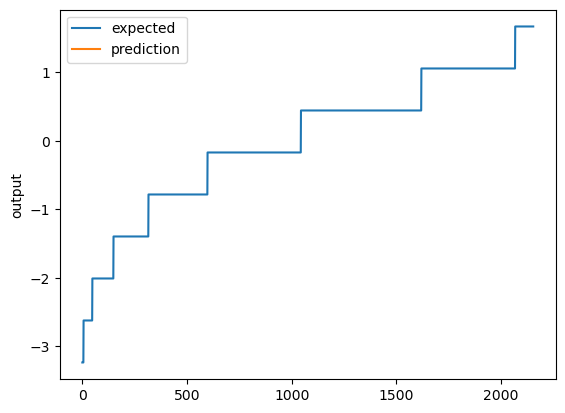

In [64]:
chart_regression(None, y_test, sort=True)

270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


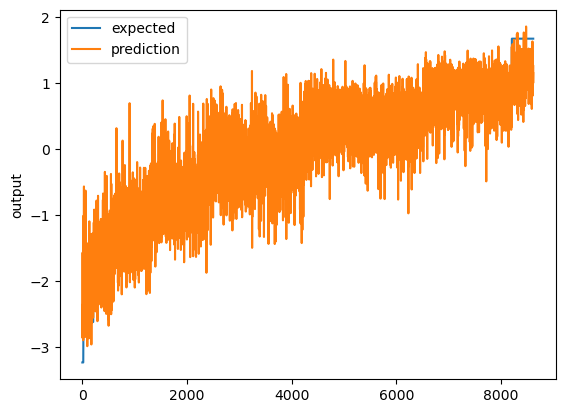

In [65]:
train_pred = model.predict(x_train)
chart_regression(train_pred.flatten(), y_train, sort=True)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


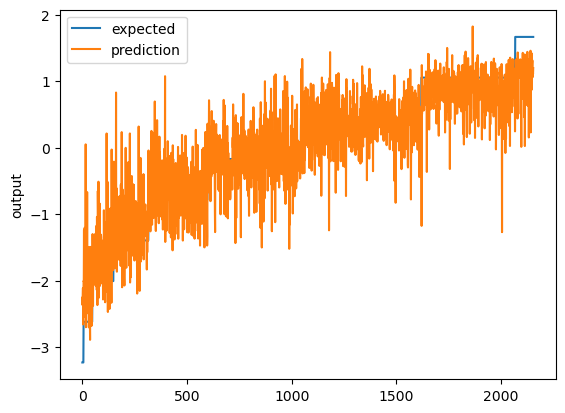

In [66]:
pred = model.predict(x_test)
chart_regression(pred.flatten(), y_test, sort=True)

### Second Approach - Predict Review Scores

Instead of processing all reviews at once, we can make a model that predicts the individual score for each review.

Afterwards, we'll average all of the predicted review scores and predict the business's rating.

#### Applying TFIDF to Reviews
Using individual reviews instead of grouped reviews.

In [22]:
print(review_filtered.shape)
review_filtered.head()

(845219, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31


In [23]:
review_df = pd.DataFrame({
    'business_id': review_filtered['business_id'],
    'text': review_filtered['text'],
    'stars': review_filtered['stars'],
})

print(review_df.shape)
review_df.head()

(845219, 3)


,business_id,text,stars
0,XQfwVwDr-v0ZS3_CbbE5Xw,"If you decide to eat here, just be aware it is...",3
1,7ATYjTIgM3jUlt4UM3IypQ,I've taken a lot of spin classes over the year...,5
3,kxX2SOes4o-D3ZQBkiMRfA,"Wow! Yummy, different, delicious. Our favo...",5
4,e4Vwtrqf-wpJfwesgvdgxQ,Cute interior and owner (?) gave us tour of up...,4
5,04UD14gamNjLY0IDYVhHJg,I am a long term frequent customer of this est...,1


In [24]:
review_vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=500, min_df=1)

review_df['stars'] = zscore(review_df['stars'])

xr = review_vectorizer.fit_transform(review_df['text'])
yr = review_df[['stars']].to_numpy()

KeyboardInterrupt: 

In [ ]:
review_vectorizer.get_feature_names_out()[:40]

array(['10', '15', '20', '30', '50', 'able', 'absolutely', 'actually',
       'add', 'ago', 'amazing', 'ambiance', 'appetizer', 'area',
       'arrived', 'ask', 'asked', 'ate', 'atmosphere', 'attentive',
       'authentic', 'available', 'average', 'away', 'awesome', 'bacon',
       'bad', 'bar', 'bartender', 'bbq', 'beans', 'beautiful', 'beef',
       'beer', 'beers', 'believe', 'best', 'better', 'big', 'birthday'],
      dtype=object)

In [ ]:
# Train/test split 80/20
xr_train, xr_test, yr_train, yr_test = train_test_split(xr, yr, test_size=0.2, random_state=42)

IndexError: Index dimension must be 1 or 2

In [ ]:
# Make the model

review_model = Sequential()
review_model.add(Dense(1000, input_dim=xr.shape[1], activation='relu'))
review_model.add(Dense(500, activation='relu'))
review_model.add(Dense(250, activation='relu'))
review_model.add(Dense(125, activation='relu'))
review_model.add(Dense(60, activation='relu'))
review_model.add(Dense(30, activation='relu'))
review_model.add(Dense(15, activation='relu'))
review_model.add(Dense(1))

review_model.compile(loss='mean_squared_error', optimizer='adam')

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
review_model.fit(xr_train, yr_train, validation_data=(xr_test,yr_test), callbacks=[monitor], verbose=2, epochs=1000)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
21131/21131 - 154s - 7ms/step - loss: 0.3510 - val_loss: 0.3382
Epoch 2/1000
21131/21131 - 154s - 7ms/step - loss: 0.3091 - val_loss: 0.3261
Epoch 3/1000
21131/21131 - 157s - 7ms/step - loss: 0.2737 - val_loss: 0.3262
Epoch 4/1000
21131/21131 - 158s - 7ms/step - loss: 0.2393 - val_loss: 0.3404
Epoch 5/1000
21131/21131 - 157s - 7ms/step - loss: 0.2101 - val_loss: 0.3469
Epoch 6/1000
21131/21131 - 159s - 8ms/step - loss: 0.1861 - val_loss: 0.3582
Epoch 7/1000
21131/21131 - 160s - 8ms/step - loss: 0.1662 - val_loss: 0.3677
Epoch 7: early stopping


In [ ]:
print_rsme(review_model, xr_test, yr_test)

5283/5283 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
RMSE Score: 0.6063734276401712


5283/5283 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


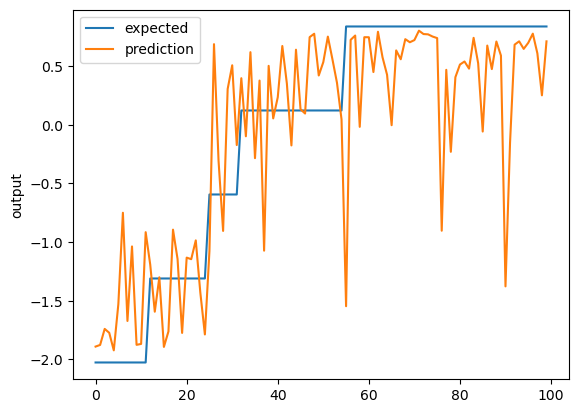

In [ ]:
pred_r = review_model.predict(xr_test)
chart_regression(pred_r.flatten()[:100], yr_test[:100], sort=True)

In [ ]:
# Get all predicted reviews and average them by business ID


# TODO LIST

Tuning the following hyperparameters when training neural networks using Tensorflow and

tabulate all the results of each model on how they affect performance in your report. Also,

save all the models you have tried as a proof in your notebook.


(see notes)

Activation: relu, sigmoid, tanh

- Number of layers and neuron count for each layer
- Optimizer: adam and sgd